# Intercellular Context Factorization with Tensor-Cell2cell

## Background

Tensor decomposition of cell-cell communication patterns, as proposed by [Armingol and Baghdassarian et al., 2022](https://www.nature.com/articles/s41467-022-31369-2), enables us to decipher context-driven intercellular communication by simultaneously accounting for an unlimited number of “contexts”. These contexts could represent samples coming from longtidinal sampling points, multiple conditions, or cellular niches.

The power of [Tensor-cell2cell](https://github.com/earmingol/cell2cell) is in its ability to decompose latent patterns of intercellular communication in an untargeted manner, in theory being able to handle cell-cell communication results coming from any experimental design, regardless of its complexity.

Simply put, tensor_cell2cell uses LIANA’s output by sample to build a 4D tensor, represented by 1) contexts, 2) interactions, 3) sender, and 4) receiver cell types. This tensor is then decomposed into a set of factors, which can be interpreted as low-dimensionality latent variables (vectors) that capture the CCC patterns across contexts.
We will combine LIANA with tensor_cell2cell to decipher potential ligand-receptor interaction changes.

## Load Packages

cell2cell, decoupler, and omnipath can be installed via pip with the following commands:

```python
pip install decoupler
pip install cell2cell
pip install omnipath
```

In [1]:
import scanpy as sc
import plotnine as p9

import liana as li
import cell2cell as c2c
import decoupler as dc # needed for pathway analysis

import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Load & Prep Data 

 As a simple example, we will look at ~25k PBMCs from 8 pooled patient lupus samples, each before and after IFN-beta stimulation ([Kang et al., 2018](https://www.nature.com/articles/nbt.4042); [GSE96583](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583)). Note that by focusing on PBMCs, for the purpose of this tutorial, we assume that coordinated events occur among them.

This dataset is downloaded from a link on Figshare; preprocessed for [pertpy](https://github.com/theislab/pertpy).

In [2]:
# load data as from CCC chapter
adata = li.testing.datasets.kang_2018()

#### Showcase anndata object

In [3]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [4]:
adata.obs.head()

,nCount_RNA,nFeature_RNA,tsne1,tsne2,condition,cluster,cell_type,patient,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters,sample,cell_abbr
index,,,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1,ctrl&1016,CD14
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1,ctrl&1256,CD14
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6,ctrl&1488,CD4T
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1,ctrl&1256,CD14
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12,ctrl&1039,DCs


In [5]:
adata.obs["cell_type"].cat.categories

Index(['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'CD8 T cells',
       'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
      dtype='object')

In [6]:
sample_key = 'sample'
condition_key = 'condition'
groupby = 'cell_type'

#### Basic QC

Note that this data has been largely pre-processed & annotated, we refer the user to the [Quality Control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) and other relevant chapters from the best-practices book for information about pre-processing and annotation steps.

In [7]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In addition to the basic QC steps, one needs to ensure that the cell groups on which they run the analysis are well defined, and stable across samples.

#### Show pre-computed UMAP

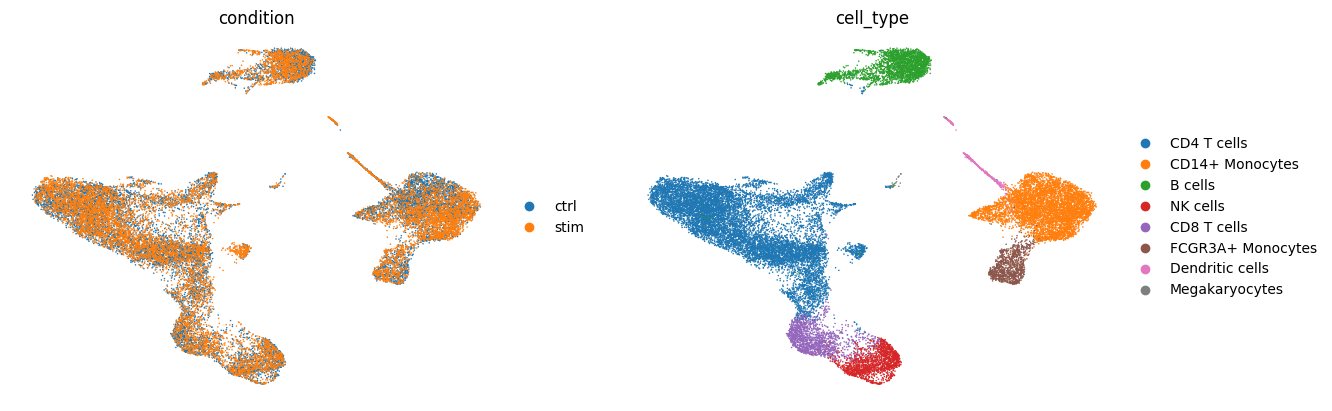

In [8]:
sc.pl.umap(adata, color=[condition_key, groupby], frameon=False)

## Ligand-Receptor Inference by Sample

Before we decompose the CCC patterns across contexts/samples with `tensor_cell2cell`, we need to run `liana` on each sample. This is because `tensor_cell2cell` uses LIANA’s output by sample to build a 4D tensor, that is later decomposed into CCC patterns. To do so, liana provides a utility function called `by_sample` that runs each method in LIANA on each sample within the `AnnData` object, and returns a long-format `pandas.DataFrame` with the results.

In this example, we will use liana's rank_aggregate method, which provides a robust rank consensus that combines the predictions of multiple ligand-receptor methods. Nevertheless, any other method can be used.

In [9]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby=groupby,
    sample_key=sample_key, # sample key by which we which to loop
    use_raw=False, 
    verbose=True, # use 'full' to show all verbose information
    n_perms=100, # reduce permutations for speed
    return_all_lrs=True, # return all LR values
    ) 

Now running: stim&1488: 100%|██████████| 16/16 [02:27<00:00,  9.21s/it]


Check results

In [10]:
adata.uns["liana_res"].sort_values("magnitude_rank").head(10)

,sample,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
480788,stim&1015,NK cells,CD8 T cells,B2M,CD3D,2.483042,0.0,2.652776,1.086438,0.628031,0.077230,0.978141,0.119143,0.0,1.998437e-08,7.178280e-13
230496,ctrl&1244,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.504210,0.0,5.661785,1.703509,2.209408,0.116978,0.985015,0.222247,0.0,8.124073e-09,8.335264e-13
670320,stim&1256,NK cells,CD8 T cells,B2M,CD3D,2.655090,0.0,3.819609,1.123354,0.749565,0.085849,0.981475,0.144068,0.0,2.078555e-08,9.917912e-13
0,ctrl&101,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.627803,0.0,6.208072,1.545891,2.279768,0.132816,0.984116,0.266597,0.0,5.695394e-09,1.326462e-12
193305,ctrl&1039,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.547695,0.0,5.674415,1.301281,1.767435,0.104337,0.981838,0.246975,0.0,9.262294e-08,2.358582e-12
45325,ctrl&107,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.544711,0.0,5.852476,1.065290,1.678028,0.104096,0.982827,0.232994,0.0,1.191677e-08,2.523211e-12
670321,stim&1256,CD8 T cells,CD8 T cells,B2M,CD3D,2.646979,0.0,3.805692,1.100260,0.731686,0.085537,0.981442,0.143954,0.0,2.078555e-08,7.934094e-12
340011,ctrl&1488,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.380374,0.0,4.891490,1.928655,2.288309,0.129141,0.984287,0.201439,0.0,3.357910e-09,1.755218e-11
480789,stim&1015,CD8 T cells,CD8 T cells,B2M,CD3D,2.469810,0.0,2.636665,1.044881,0.593775,0.076761,0.978075,0.118691,0.0,1.998437e-08,1.815579e-11
193306,ctrl&1039,CD14+ Monocytes,CD14+ Monocytes,TIMP1,CD63,2.425800,0.0,5.273580,1.221836,2.444705,0.096966,0.981173,0.236313,0.0,1.667443e-07,1.886791e-11


<div class="alert alert-info">

**Note**
    
<h4> by_sample </h4>

We see that in addition to the usual results, we also get `sample` as a column which corresponds to the name of the `sample_key` in the `AnnData` object.

</div>  

Now that we have obtained results by sample, we can use a dotplot by sample to visualize the ligand-receptor interactions. Let's pick arbitrarily the interactions with the highest `magnitude_rank`.

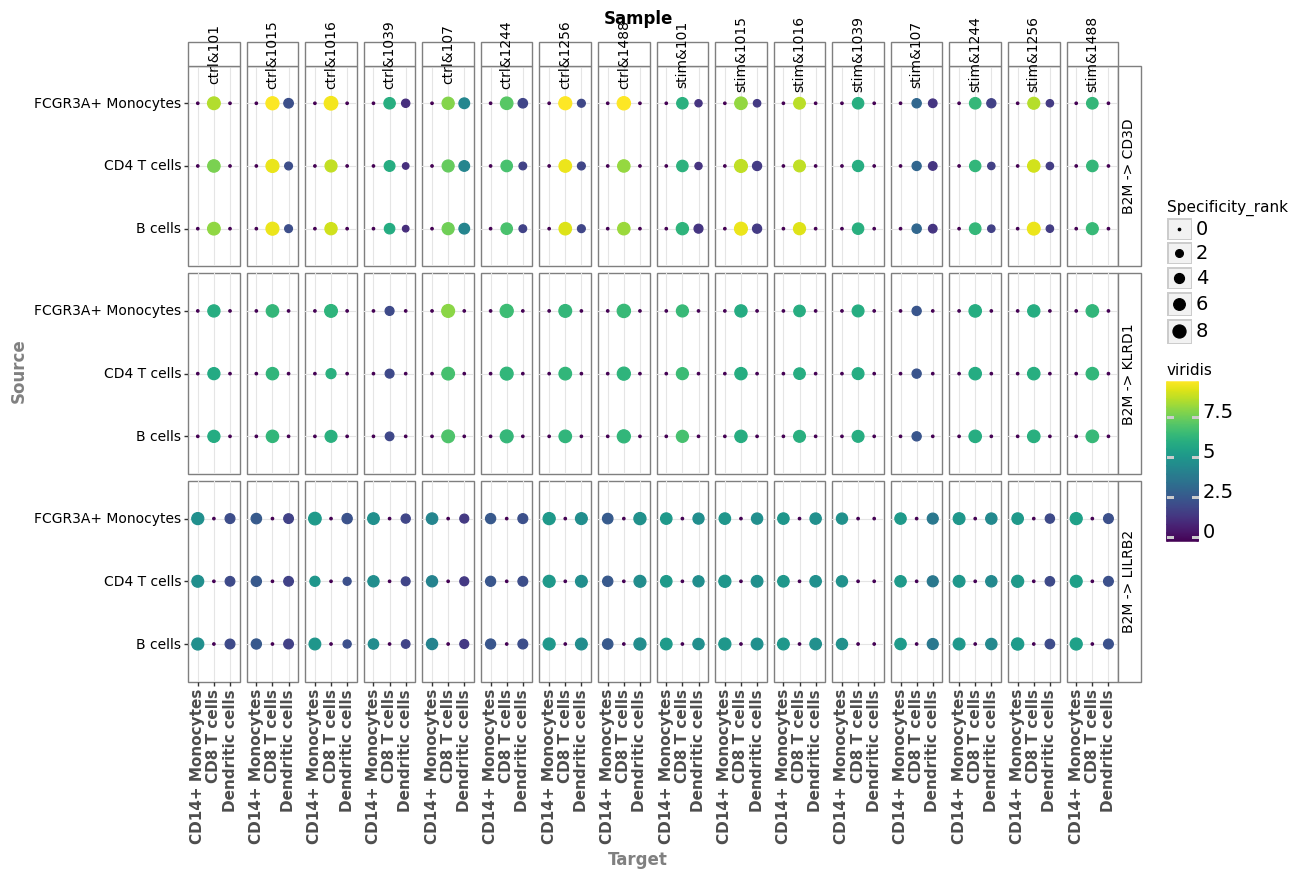

<ggplot: (8731133120335)>

In [11]:
(li.pl.dotplot_by_sample(adata, sample_key=sample_key,
                         colour="magnitude_rank", size="specificity_rank",
                         source_labels=["CD4 T cells", "B cells", "FCGR3A+ Monocytes"],
                         target_labels=["CD8 T cells", 'Dendritic cells', 'CD14+ Monocytes'],
                         ligand_complex=["B2M"],
                         inverse_colour=True,
                         inverse_size=True,
                         receptor_complex=["KLRD1", "LILRB2", "CD3D"],
                         figure_size=(12, 8),
                         size_range=(0.5, 5),
                         ) +
    # rotate facet labels
    p9.theme(strip_text=p9.element_text(size=10, colour="black", angle=90))
 )

Even on a small subset interactions and cell types, we can see that interpretation becomes challenging. To overcome this, we can use MOFA to find the variable CCC patterns across contexts/samples.

## Building a Tensor

Before we can decompose the tensor, we need to build it. To do so, we will use the `to_tensor_c2c` function from `liana`. This function takes as input the `pandas.DataFrame` with the results from `liana.by_sample`, and returns a `cell2cell.tensor.PrebuiltTensor` object. This object contains the tensor, as well as other useful utility functions.

Note that the way that we build the tensor can impact the results that we obtain. This is largely controlled by the `how`, `lr_fill`, and `cell_fill` parameters, but these are out of the scope of this tutorial. For more information, please refer to the [tensor_cell2cell documentation](https://earmingol.github.io/cell2cell/), as well as the `c2c.tensor.external_scores.dataframes_to_tensor` function. 

In [12]:
tensor = li.multi.to_tensor_c2c(adata,
                                sample_key=sample_key,
                                score_key='magnitude_rank', # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )

100%|██████████| 16/16 [00:46<00:00,  2.91s/it]


We can check the shape of the tensor, represented as (Contexts, Interactions, Senders, Receivers).

In [13]:
tensor.tensor.shape

(16, 441, 7, 7)

One can save the tensor to disk, by using the `c2c.io.export_variable_with_pickle` function

In [14]:
c2c.io.export_variable_with_pickle(tensor, "tensor_tutorial.pkl")

tensor_tutorial.pkl  was correctly saved.


Build Metadata 

In [15]:
context_dict = adata.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

#### Running Tensor-cell2cell

Let's now run the Tensor decomposition pipeline of Tensor-cell2cell. This function includes optimal rank estimation, as well as PARAFAC decomposition of the tensor. For more information, please refer to the [Tensor-cell2cell manuscript](https://www.nature.com/articles/s41467-022-31369-2).

<div class="alert alert-info">

**Note**
    
<h5> Optimal Rank Estimation </h5>

Here, we have omitted the optimal rank estimation step, as the optimal rank was precomputed. This can be a computationally intensive process, and we recommend using a GPU for this step. If your machine does not have a GPU, you can either use the device='cpu' option, or alternatively [Google Colab](https://colab.research.google.com/drive/1pwG0JjD5P3EGTWKFSXKGIWBvY6LUX9uR?usp=sharing) to run this step on the prebuilt Tensor.

</div>  


In [16]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=6, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be. 
                                                    random_state=0, # Random seed for reproducibility
                                                    device='cpu', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=20, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )

Running Tensor Factorization


Plot Tensor Decomposition results

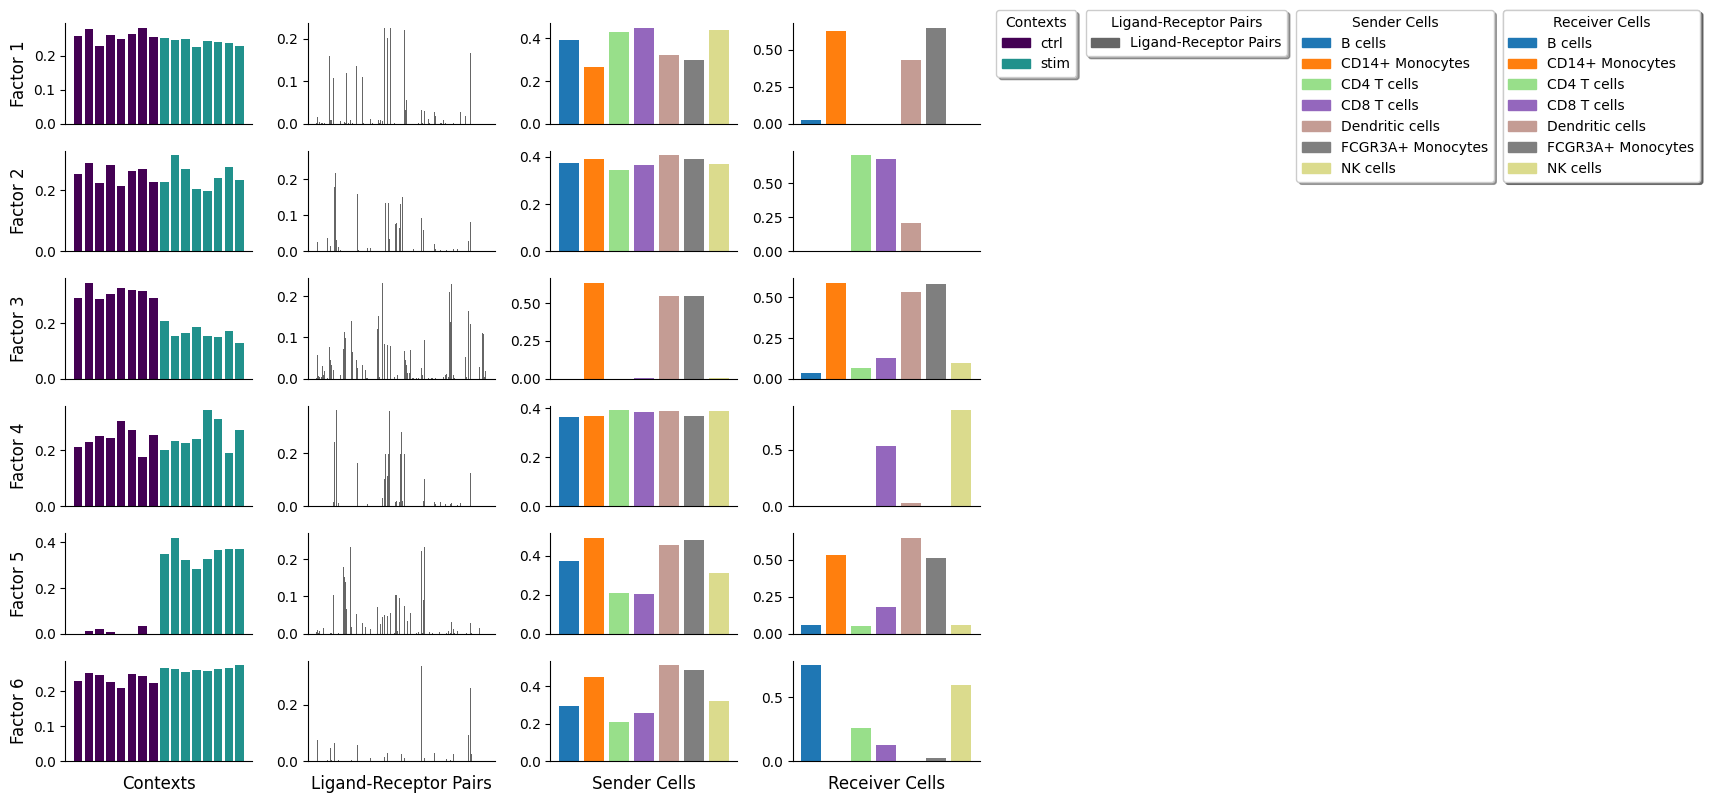

In [17]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['viridis', 'Dark2_r', 'tab20', 'tab20'],
                                                 fontsize=10, # Font size of the figures generated
                                                 )

Here, we see clearly that Factor 5 is associated with the IFN-beta stimulation.

## Factorization Results

To get a more detailed look we can access the factors and loadings of the decomposition. As expected, for each factor we get four vectors, one for each dimension of the tensor. We can access those as follows:

In [18]:
factors = tensor.factors

In [19]:
factors.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

We can see the Factor scores assigned to each of the samples:

In [20]:
factors['Contexts']

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
ctrl&101,0.257491,0.250515,0.291238,0.209750,4.045002e-11,0.230164
ctrl&1015,0.277434,0.289020,0.347047,0.229742,9.722763e-03,0.251355
ctrl&1016,0.227853,0.222026,0.288151,0.249341,1.919019e-02,0.245270
ctrl&1039,0.261392,0.280397,0.304960,0.242466,5.143912e-03,0.226567
ctrl&107,0.249066,0.211942,0.328490,0.304108,1.931906e-06,0.209220
ctrl&1244,0.264326,0.262837,0.320916,0.272101,2.084333e-04,0.250919
ctrl&1256,0.281715,0.269388,0.317463,0.174800,3.152366e-02,0.242772
ctrl&1488,0.254299,0.225073,0.290722,0.253139,1.752458e-07,0.223687
stim&101,0.250849,0.224470,0.207676,0.200306,3.511370e-01,0.266080
stim&1015,0.244471,0.313315,0.155530,0.230140,4.200566e-01,0.264417


We can also check the loadings of each factor, which are the weights assigned to each interaction, sender, and receiver cell type.
So, let's check the ligand-receptor interactions with the highest loadings in `Factor 5`.

In [21]:
lr_loadings = factors['Ligand-Receptor Pairs']
lr_loadings.sort_values("Factor 5", ascending=False).head(10)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
CCL8^CCR1,0.014531,1.082397e-43,1.009739e-08,1.382158e-54,0.256470,2.090158e-99
LGALS9^CD47,0.017797,7.054908e-02,9.748617e-02,3.277711e-05,0.248650,2.394954e-01
LGALS9^PTPRC,0.015729,7.894369e-02,1.006120e-01,1.665215e-03,0.247889,2.391179e-01
LGALS9^CD44,0.014985,7.810905e-02,1.030404e-01,1.724222e-03,0.245097,2.365562e-01
CCL8^CCR5,0.009039,4.910144e-39,1.070083e-08,7.998036e-51,0.232782,1.708863e-107
LGALS9^HAVCR2,0.028643,1.502122e-23,9.318549e-02,1.006984e-01,0.231562,1.078784e-02
LGALS1^CD69,0.031894,9.359272e-02,2.656095e-02,9.371983e-08,0.219863,3.382630e-01
TNFSF13B^CD40,0.004711,2.919905e-41,7.997553e-02,4.810676e-74,0.219077,9.893856e-02
TNFSF13B^HLA-DPB1,0.003808,3.022707e-02,1.601356e-01,1.198362e-03,0.205252,1.865001e-01
CCL2^CCR1,0.000218,4.510676e-46,8.349771e-02,1.400019e-58,0.200234,1.767179e-104


Though anecdotal in this example, we can see that the members of the interaction with the highest loading (CCL8->CCR1) in `Factor 5` were reported as [associated with IFN-beta stimulation](https://jamanetwork.com/journals/jamaneurology/fullarticle/798164).

## Downstream Analysis

Let's also perform a basic enrichment analysis on the results above. We will use [decoupler](https://github.com/saezlab/decoupler-py) with pathway genesets from [PROGENy](https://github.com/saezlab/progeny).

In [22]:
# load PROGENy pathways
net = dc.get_progeny(organism='human', top=5000)

In [23]:
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

In [24]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_separator="^")
lr_progeny.head()

,source,interaction,weight
1,JAK-STAT,LGALS9^PTPRC,1.307807
74,Androgen,SEMA4D^MET,-0.831693
90,Androgen,HGF^MET,-1.288956
106,Androgen,TIMP3^MET,-1.122612
151,NFkB,SELE^CD44,3.332552


In [26]:
# run enrichment analysis
estimate, pvals = dc.run_mlm(lr_loadings.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

Check Enrichment results for Factor 5

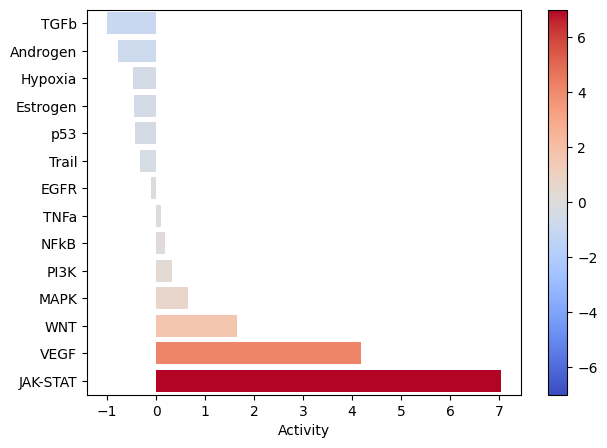

In [27]:
dc.plot_barplot(estimate, 'Factor 5', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)

We can see that the most enriched PROGENy pathway in Factor 5 is the JAK-STAT signaling pathway, which is consistent with what we would expect.

## Outlook & Further Analysis

There are different ways to explore these results downstream of the tensor decomposition, but these are out of scope for this tutorial.

Stay tuned for more in-depth tutorials with `Tensor-cell2cell` and `liana`! In the meantime, we refer the user to the [Tensor-cell2cell tutorials](https://earmingol.github.io/cell2cell/tutorials/ASD/02-Factor-Specific-ASD/)